# CS 190H/292H Midterm
### Approximating the Sigmoid activation function by way of transition probability response function
Firstly, it's important we define some basic functions. We need not implement a circuit just yet, as we can model everything as some basic matrix multiplication functions. <br>
We need to make:
1. A rotation gate
2. A unitary as a composite of equiangular rotation gates
3. The transition probability response function itself
4. A JSON utility for saving/exporting $\Phi$ sets for your brevity.

In [34]:
import numpy as np
from typing import List
from scipy.linalg import expm
import matplotlib.pyplot as plt
import json

In [35]:
# A basic rotation operator
def R(phi: float, theta: float):
    X = np.array([[0, 1], [1, 0]])
    Y = np.array([ [0, -1j], [1j, 0] ])
    return expm(-1j * theta / 2 * (np.cos(phi)*X + np.sin(phi)*Y))

print(R(np.pi / 2, np.pi / 2))

[[ 0.70710678+3.08148791e-33j -0.70710678-4.32978028e-17j]
 [ 0.70710678-4.32978028e-17j  0.70710678+0.00000000e+00j]]


In [36]:
# vphi -> list of phi_1, phi_2, ..., etc
def eqang_U(vphi: List[float], theta: float):
    U = np.array([[1.+0.j, 0.+0.j], [0.+0.j, 1.+0.j]])
    for phi in vphi:
        U = U @ R(phi, theta)
    return U

print(eqang_U([np.pi/2], np.pi/2))

[[ 0.70710678+3.08148791e-33j -0.70710678-4.32978028e-17j]
 [ 0.70710678-4.32978028e-17j  0.70710678+0.00000000e+00j]]


Text(0, 0.5, '$f_{\\vec{\\phi}}(\\theta)$')

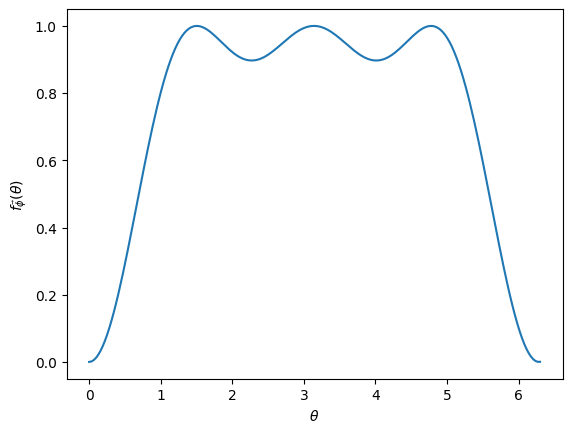

In [37]:
#Transition response function
# Want to find a vphi s.t. tprf(vphi, theta) ~= sigmoid(theta)
def tprf(vphi: List[float], theta: float):
    ket0, ket1 = np.array([1, 0]), np.array([0,1])
    return np.pow(np.abs(ket0.transpose().conj() @ ((eqang_U(vphi, theta)) @ ket1) ), 2)

x = np.linspace(0, 6.3, 200)
y = [tprf([0, 1.5, 0], theta) for theta in x]
plt.plot(x, y)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$f_{\vec{\phi}}(\theta)$')

In [38]:
def save_floats_to_json(float_array, filename="data.json"):
    """Saves a numpy array of floats to a JSON file with the length as the key, avoiding duplicates."""
    data = {}
    try:
        with open(filename, "r") as file:
            data = json.load(file)  # Load existing data
    except (FileNotFoundError, json.JSONDecodeError):
        pass  # If file doesn't exist or is empty, start fresh
    
    float_list = float_array.tolist()
    existing_list = data.get(str(len(float_array)), [])
    
    if float_list not in existing_list:
        data[str(len(float_array))] = float_list
    
    with open(filename, "w") as file:
        json.dump(data, file, indent=4)

def get_floats_from_json(size, filename="data.json"):
    """Retrieves a numpy array of floats from a JSON file based on the given key (size)."""
    try:
        with open(filename, "r") as file:
            data = json.load(file)
            return np.array(data.get(str(size), []))  # Return the numpy array if exists, else empty array
    except (FileNotFoundError, json.JSONDecodeError):
        return np.array([])  # Return empty array if file doesn't exist or has invalid JSON

We now have a way to plot and track the probability response function $f_{\vec{\phi}}(\theta)=|\bra{0} R_{\phi_0}(\theta)R_{\phi_1}(\theta)\cdots R_{\phi_N}(\theta)\ket{1}|^2$ and functions to return corresponding unitaries for both the composite gate and the individual equiangular gates.
# Modelling the Sigmoid
### Best-fit
Our goal is to create an objective function (derived from https://arxiv.org/pdf/2002.11649, although with some differences since there is less symmetry to using transition probability response function instead of the $Re(\bra{0} \hat U_\Phi(\theta)\ket{0})$) as follows:
$$ L(\Phi) = \frac{1}{d} \sum_{j=0}^d | |\bra{0}\hat U_\Phi(\theta_j)\ket{1} |^2 - \sigma(\theta_j) |^2 $$
where the points $\theta_j$ are from some set of numbers to normalize onto, it should be of length $L$. Chebyshev norm works, as does other ranges
This provides a heuristic of sorts from which we want to minimize as much as possible, very akin to a neural network cost function. The difference being, of course, we are calculating the gradient numerically via BFGS. We can thus use classical, numerical optimization methods that reduce the error as a function of $\Phi$.

In [39]:
from scipy.optimize import minimize

In [40]:
sigmoid = lambda theta: 1 / (1 + np.exp(-theta))

In [41]:
# objective function as defined above
def objective_func(phiset: List[float], func, norm: List[float]):
    d = len(phiset)
    
    return (1 / d) * sum([ np.abs( tprf(phiset, xi) - func(xi) )**2 for xi in norm ])

In [42]:
# objective function optimizer
# This could largely be reduced to just returning the SciPy minimize function, but there is a lot of extra in here to prevent falling in local minimia
# Out of three iterations, we operate on the best phi as a jumping find to find the next minimization, with some added noise
def QSPBFGS(phi0: np.ndarray, func, tolerance: float, norm: List[float], restarts=3):
    obj_func = lambda PHI: objective_func(PHI, func, norm) # Isolate to just one input for scipy.minimize
    best_phi = phi0.copy() #hold a "best" phi -
    best_err = obj_func(best_phi) #hold a min err
    
    for i in range(restarts):
        # Add slight noise to best to try and avoid deterministic local minima -> retrying the same thing can have varying best fits! try multiple times
        current_phi = best_phi + np.random.normal(0, 0.05, size=len(best_phi))
        res = minimize(obj_func, current_phi, method='l-bfgs-b',
                       tol=tolerance / 10,
                       options={'maxiter': 100000, 'maxfun': 100000})
        print("Iteration ", i, " complete.")
        if res.fun < best_err: # save best result / error
            best_err = res.fun
            best_phi = res.x
        if best_err <= tolerance: # if we're below threshold we can just break
            break
    
    return best_phi


This is a pretty powerful optimizer. As laid out in the comments, we're optimizing the objective function to fit the $\phi$ values to the correct input over some set of $\theta$ values. The chebyshev norm or a `np.linspace` (evenly spaced sequence) works too. <br>
A few caveats:
1. We could attempt to fir our $\phi$ values strictly to the $\sigma(\theta)$ function, but this will cost us a lot of accuracy. When $\theta = 0$, we have the following:
$$f_{\vec{\phi}}(0)=|\bra{0} R_{\phi_0}(0)R_{\phi_1}(0)\cdots R_{\phi_N}(0)\ket{1}|^2=|\bra{0}II\cdots I\ket{1}|^2 = |\braket{0 | 1}|^2 = 0$$
So regardless of $\Phi$, $\theta = 0 \implies f_{\Phi}(\theta) = 0$, which contradicts with the fact that $\sigma(0) = 0.5$. While the `QSPBFGS` function *will* still attempt to fit to the $\sigma(\theta)$ and might even do so with a competent level of accuracy, we can make its life easier by approximating $\sigma(\theta) - \frac{1}{2}$, shifting the function down. This also happens to be the strictly odd component of the original $\sigma(\theta)$ function, and so instead of needing to approximate an infinitely large jump from 0 to $\frac{1}{2}$, it just approximates the actual function itself. The only issue is we have to add $\frac{1}{2}$ classically to the entire function approximation. <br>
2. Of course, however, this provides a range issue. The transition probability response function $f_{\Phi}(\theta)$ is, as the name implies, is a *probability* function. Therefore, the TPRF can only model functions with a codomain $\subseteq [0, 1]$, which works fine for the original $\sigma(\theta)$ function, but our new, shifted function $\sigma(\theta) - \frac{1}{2}$ unfortunately has the codomain $[-\frac{1}{2}, \frac{1}{2}]$. Recall, however, that we are now modelling the odd part of the $\sigma(\theta)$ function, which necessarily means that we can exclusively model positive values of $\theta$ which will suffice to model negative values. So, if $\theta < 0$, we can instead compute $-f_{\Phi}(\theta)$, which solves any codomain issues. Additionally, our $\Phi$ only needs to fit to half of the original range, allowing for even better accuracy, i.e.
$$ f_{\Phi}(\theta) \approx \begin{cases} \sigma(\theta) - \frac{1}{2}, & \theta \geq 0 \\ -\sigma(\theta) + \frac{1}{2}, & \theta < 0 \end{cases} $$
3. The $\sigma(\theta)$ function is designed to clamp to $[0, 1]$. Thus, the closest we can get to $f_{\Phi}(\theta)$, the better our approximation. However, better approximation comes at the cost of higher degrees of $L$, so below are a few different approximations based on the amount of error acceptable. <br> That about covers it! Below are a few approximations for different values of $L$. We will also use the heuristic $|f_{\Phi}(\theta) + \frac{1}{2} - \sigma(\phi)|$ to see the realized error for each point, but the distance $1 - f_{\Phi}(\theta_L)$ is also a good heuristic, since $f_{\Phi}(\theta_L)$ is the last value for which the objective function normalizes to. <br>
The headers for the following will provide information on certain $L$ values. "Error" refers to the distance labeled before. Also note that, since the `QSPBFGS` function uses some randomization to avoid local minima, it is entirely possible to rerun each Python cell and get different approximations, but they should all be within the same neighborhood of error, for both heuristics. We also plot the last $\theta_j$ value as a vertical line for reference of the distance error.

I have pre-computed the $\Phi$ sets below for the sake of your brevity, since the time complexity is polynomial in $L$, it can take awhile for some of this compute to churn. If you do want to see the values computed in real time, set the `preset_flag` to `False`, and then run all the below cells. After some time, all of them will be generated. 

In [43]:
preset_flag = True
save_values = False

### $L = 15$, normalized to $\theta_j \in$ `np.linspace(0, 2.875, L)`. ~$0.0534033297998$ error.

Text(0.5, 0, '$\\theta$')

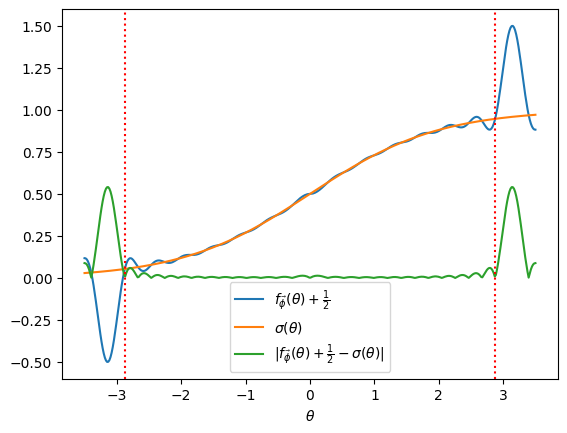

In [44]:
L = 15
phi0 = np.linspace(np.pi/4, -np.pi/4, L)
final_theta = 2.875

#Shifted function
res = QSPBFGS(phi0, lambda x: 1 / (1+np.exp(-x)) - 0.5, 0.000000001, np.linspace(0, final_theta, L)) if not preset_flag else get_floats_from_json(L, "phisets.json")
if save_values:
    save_floats_to_json(res, "phisets.json")

x = np.linspace(-3.5, 3.5, 400)
#Note the shifts and conditional sign flips to accomdate for our previous shifting / domain issues
y1 = [1 / 2 +tprf(res, theta * (-1 if theta < 0 else 1)) * (-1 if theta < 0 else 1) for theta in x]
y2 = [1 / (1 + np.exp(-theta)) for theta in x]
y3 = [np.abs(y1[i] - y2[i]) for i in range(400)]
plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)
# plot last norm value
plt.axvline(final_theta, linestyle=':', color='r')
plt.axvline(-final_theta, linestyle=':', color='r')
plt.legend([r'$f_{\vec{\phi}}(\theta) + \frac{1}{2}$', r'$\sigma(\theta)$', r'$|f_{\vec{\phi}}(\theta) + \frac{1}{2} - \sigma(\theta)|$' ])
plt.xlabel(r'$\theta$')


You could possibly change the boundaries, but it seemed `np.linspace(0, 2.875, L)` seemed the best balance of accuracy and effective domain.

### $L = 25$, normalized to $\theta_j \in$ `np.linspace(0, 2.95, L)`. ~$0.0497365115586$ error.

Text(0.5, 0, '$\\theta$')

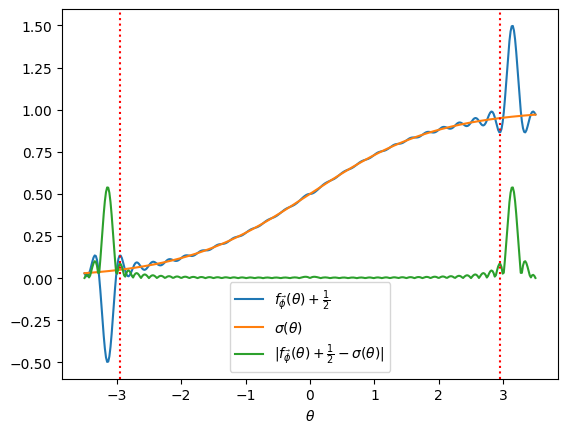

In [45]:
L = 25
phi0 = np.linspace(np.pi/4, -np.pi/4, L)
final_theta = 2.95

#Shifted function
res = QSPBFGS(phi0, lambda x: 1 / (1+np.exp(-x)) - 0.5, 0.000000001, np.linspace(0, final_theta, L)) if not preset_flag else get_floats_from_json(L, "phisets.json")
if save_values:
    save_floats_to_json(res, "phisets.json")

x = np.linspace(-3.5, 3.5, 400)
#Note the shifts and conditional sign flips to accomdate for our previous shifting / domain issues
y1 = [1 / 2 +tprf(res, theta * (-1 if theta < 0 else 1)) * (-1 if theta < 0 else 1) for theta in x]
y2 = [1 / (1 + np.exp(-theta)) for theta in x]
y3 = [np.abs(y1[i] - y2[i]) for i in range(400)]
plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)
# plot last norm value
plt.axvline(final_theta, linestyle=':', color='r')
plt.axvline(-final_theta, linestyle=':', color='r')
plt.legend([r'$f_{\vec{\phi}}(\theta) + \frac{1}{2}$', r'$\sigma(\theta)$', r'$|f_{\vec{\phi}}(\theta) + \frac{1}{2} - \sigma(\theta)|$' ])
plt.xlabel(r'$\theta$')


### $L = 25$, normalized to $\theta_j \in$ `np.linspace(0, 3, L)`. ~$0.0474258731776$ error.

Text(0.5, 0, '$\\theta$')

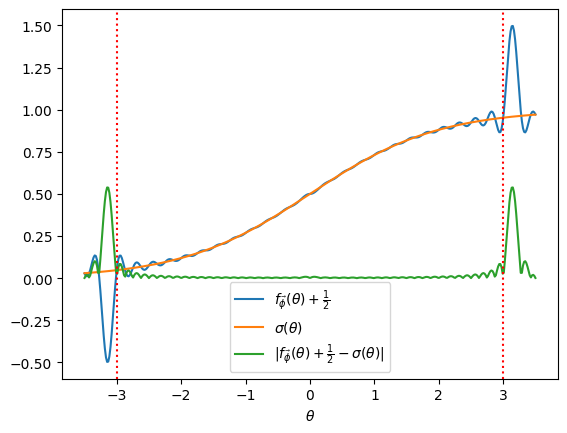

In [46]:
L = 25
phi0 = np.linspace(np.pi/4, -np.pi/4, L)
final_theta = 3

#Shifted function
res = QSPBFGS(phi0, lambda x: 1 / (1+np.exp(-x)) - 0.5, 0.000000001, np.linspace(0, final_theta, L)) if not preset_flag else get_floats_from_json(L, "phisets.json")
if save_values:
    save_floats_to_json(res, "phisets.json")

x = np.linspace(-3.5, 3.5, 400)
#Note the shifts and conditional sign flips to accomdate for our previous shifting / domain issues
y1 = [1 / 2 +tprf(res, theta * (-1 if theta < 0 else 1)) * (-1 if theta < 0 else 1) for theta in x]
y2 = [1 / (1 + np.exp(-theta)) for theta in x]
y3 = [np.abs(y1[i] - y2[i]) for i in range(400)]
plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)
# plot last norm value
plt.axvline(final_theta, linestyle=':', color='r')
plt.axvline(-final_theta, linestyle=':', color='r')
plt.legend([r'$f_{\vec{\phi}}(\theta) + \frac{1}{2}$', r'$\sigma(\theta)$', r'$|f_{\vec{\phi}}(\theta) + \frac{1}{2} - \sigma(\theta)|$' ])
plt.xlabel(r'$\theta$')


### $L = 30$, normalized to $\theta_j \in$ `np.linspace(0, 3, L)`. ~$0.0474258731776$ error.

Text(0.5, 0, '$\\theta$')

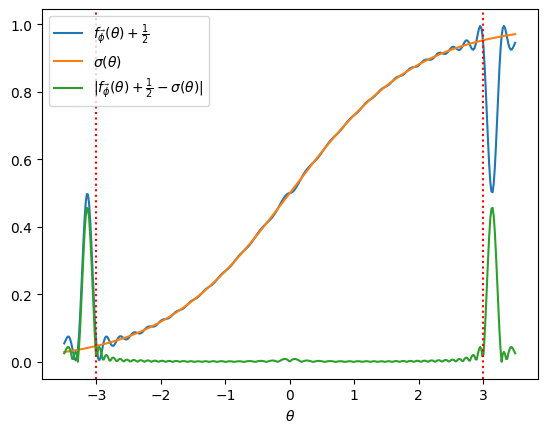

In [47]:
L = 30
phi0 = np.linspace(np.pi/4, -np.pi/4, L)
final_theta = 3

#Shifted function
res = QSPBFGS(phi0, lambda x: 1 / (1+np.exp(-x)) - 0.5, 0.000000001, np.linspace(0, final_theta, L)) if not preset_flag else get_floats_from_json(L, "phisets.json")
if save_values:
    save_floats_to_json(res, "phisets.json")

x = np.linspace(-3.5, 3.5, 400)
#Note the shifts and conditional sign flips to accomdate for our previous shifting / domain issues
y1 = [1 / 2 +tprf(res, theta * (-1 if theta < 0 else 1)) * (-1 if theta < 0 else 1) for theta in x]
y2 = [1 / (1 + np.exp(-theta)) for theta in x]
y3 = [np.abs(y1[i] - y2[i]) for i in range(400)]
plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)
# plot last norm value
plt.axvline(final_theta, linestyle=':', color='r')
plt.axvline(-final_theta, linestyle=':', color='r')
plt.legend([r'$f_{\vec{\phi}}(\theta) + \frac{1}{2}$', r'$\sigma(\theta)$', r'$|f_{\vec{\phi}}(\theta) + \frac{1}{2} - \sigma(\theta)|$' ])
plt.xlabel(r'$\theta$')


# Realizing a Neural Network with the TPRF sigmoid

### The Lazy Method

Lazily, we can utilize our sigmoid by getting information from a conventional neural network and then using that as the $\theta$ parameter, first with the convention that we clamp to the final/first (depending on sign) $\theta_j$ in the `linspace` sequence. Then we can run the basic circuit below and sum the number of 1 qubits divided by the total number of qubits classically, which will be near our sigmoid - note that because we shifted our function, we will have to apply that shifting in the end. The exact workflow: <br>
1. Given an input from a neural network, clamp it based on the model you're using (I will be using the 30-degree L from [-3, 3], however the 15-degree L from [-2.875, 2.875] is also a very performant $L$ value). So, we clamp to -3, 3. Then, if negative, flip the input. 
2. Run a circuit with $n$ qubits, where for greater $n$ the closer to a sigmoid you will have, where every circuit is just the equiangular Unitary.
3. Count the number of 1's in the resulting bit-string, and divide by $n$. Remember our function is shifted by $\frac{1}{2}$, so add 0.5.
4. If the input was originally negative, find the complement probability (1 - output). <br>
An example is below.

In [92]:
from qiskit import QuantumRegister, QuantumCircuit, transpile
from qiskit.circuit.library import UnitaryGate
from qiskit_aer import AerSimulator

QUBITS = 20

qr = QuantumRegister(QUBITS)
qc = QuantumCircuit(qr)

#Taken from a neural network. Make sure it is clamped to the domain of the linspace of the Phiset.
THETA_VALUE = 2.5

is_neg = (THETA_VALUE < 0)

if is_neg:
    THETA_VALUE *= -1

# Input value 0.55
u_theta = UnitaryGate(eqang_U(res, 2.5), label=r'$U_{\Phi}(\theta)$')

for i in range(QUBITS):
    qc.append(u_theta, [i])

qc.measure_all()

aer = AerSimulator()
sim = transpile(qc, backend=aer)
aerres = aer.run(sim, shots=1).result()
bitstr = list(aerres.get_counts().keys())[0]

#We start with the total number of qubits, assumed to all be 1
onescount = 0
for c in bitstr:
    onescount += 1 if c == '1' else 0

final_sig_value = onescount / QUBITS + 0.5

if is_neg:
    print(1 - final_sig_value)
else:
    print(final_sig_value)
    



0.8


We can improve this a little further by averaging the value over several shots.

In [99]:
from qiskit import QuantumRegister, QuantumCircuit, transpile
from qiskit.circuit.library import UnitaryGate
from qiskit_aer import AerSimulator

QUBITS = 20

qr = QuantumRegister(QUBITS)
qc = QuantumCircuit(qr)

#Taken from a neural network. Make sure it is clamped to the domain of the linspace of the Phiset.
THETA_VALUE = 2.5

is_neg = (THETA_VALUE < 0)

if is_neg:
    THETA_VALUE *= -1

# Input value 0.55
u_theta = UnitaryGate(eqang_U(res, 2.5), label=r'$U_{\Phi}(\theta)$')

for i in range(QUBITS):
    qc.append(u_theta, [i])

qc.measure_all()

aer = AerSimulator()
sim = transpile(qc, backend=aer)
aerres = aer.run(sim, shots=1000).result()
bitstrs = list(aerres.get_counts().keys())

#We start with the total number of qubits, assumed to all be 1
average_val = 0
for bitstr in bitstrs:
    onescount = 0
    for c in bitstr:
        onescount += 1 if c == '1' else 0

    final_sig_value = onescount / QUBITS + 0.5

    if is_neg:
        average_val += (1 - final_sig_value)
    else:
        average_val += (final_sig_value)
        
# sigmoid value!
print(average_val / 1000)
    



0.9313000000000008


Then, you pipe this value back into the neural network, and the quantum approximation is now integrated into a neural network.

# A Possible QNN Model - Mostly Quantum
note that this the following information is mostly a guess/basic extrapolation of the above math/code. The 'lazy' method is a fully realized neural network that implements the quantum sigmoid we've approximated. There may be flaws/oversights, but it is meant as an idea of what a QNN could look like. A fully realized version is above.

I'm going to proceed in outlining a very rough sketch of what I imagine implementing a quantum neural network could be, based off of how we optimized the original sigmoid. The lazy method is perfectly valid, but I will attempt to extend it a little further. <br>
We were able to fit the TPRF to the sigmoid by way of cost-optimization, the same way as in neural networks, especially since the TPRF can be computed classically. We could possibly model it as follows:
$$\ket{0} --- R_{\phi_11}(\theta) --- R_{\phi_12}(\theta) --- \cdots --- R_{\phi_{1N}}(\theta) --- [ U ] --- [\text[measure]] $$
$$\ket{0} --- R_{\phi_21}(\theta) --- R_{\phi_22}(\theta) --- \cdots --- R_{\phi_{2N}}(\theta) --- [ U ] --- [\text[measure]] $$
$$ \vdots $$
$$\ket{0} --- R_{\phi_{N1}}(\theta) --- R_{\phi_{N2}}(\theta) --- \cdots --- R_{\phi_{NN}}(\theta) --- [ U ] --- [\text[measure]] $$

where we now have a sort of $\Phi$ matrix, akin to a normal NN. The $[ U ]$ column represents a single unitary that unifies each of the qubits, allowing them to interact/talk. What specifically this unitary could be is up for interpretation, for example, it could do nothing. I will cover different implementations in the proceeding texts, but after measuring, we can use the output and normalize the resulting bitstring by converting into a decimal integer then piping it through the sigmoid.